Set path and noise

In [ ]:
fname="/content/drive/MyDrive/Set9/image_F16_512rgb.png"
noise=25 #gaussian noise

SIREN model

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import time



def get_origin_mgrid(sidelen1,sidelen2, dim=2):
    '''Generates coordinatesin a range of -1 to 1: if width is not equal to highth, the smaller one will be reduced in equal proportion '''
    if sidelen1 >=sidelen2:
      tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen1)])
      mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    
      minor=int((sidelen1-sidelen2)/2)
      mgrid=mgrid[:,minor:sidelen2+minor]
    if sidelen1 <sidelen2:
      tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen2)])
      mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
      
      minor=int((sidelen2-sidelen1)/2)
      mgrid=mgrid[minor:sidelen1+minor,:]
    mgrid = mgrid.reshape(-1, dim)
   
    return mgrid

In [ ]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        



Set gaussian noise and Initialize

In [ ]:
def add_gaussian_noise(img, sigma):
   
    if sigma > 0:
        noise = np.random.normal(scale=sigma , size=img.shape).astype(np.float32)
        
        noisy_img = (img + noise).astype(np.float32)
    else:
        noisy_img = img.astype(np.float32)
    #noisy_img=np.clip(noisy_img, 0.0, 1.0)
    return noisy_img

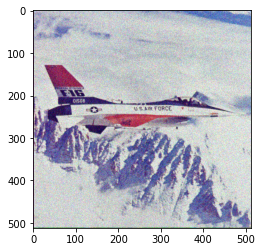

torch.Size([3, 512, 512])


/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (5): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (6): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (7): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [ ]:
def get_image(fname,noise):
    
    
    img = (np.array( Image.open(fname)).astype(np.float32)/255-0.5)*2
    #img = np.expand_dims(img, axis=2)
    
    img= add_gaussian_noise(img, noise*2/255)
    img=np.clip(img,-1,1)
    
   
    
    
    plt.imshow(np.squeeze((img+1)/2))
    
    plt.pause(0.1)
   
    noisy_tensor = torch.tensor(img).permute(2,0,1)
    return noisy_tensor
class ImageFitting(Dataset):
    def __init__(self, fname,noise):
        super().__init__()
        img = get_image(fname,noise)
        #self.pixels = img.permute(1, 2, 0).view(-1, 1)
        print(img.shape)
       
        self.pixels = img.permute(1, 2, 0).view(-1, 3)
        
        self.coords = get_origin_mgrid(img.shape[1],img.shape[2],dim=2)
        
    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
          
        return self.coords, self.pixels
im=Image.open(fname)
w,h=im.size
sidelength1=h
sidelength2=w
image = ImageFitting(fname,noise)
dataloader = DataLoader(image, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=3, hidden_features=256, 
                  hidden_layers=6, outermost_linear=True)
img_siren.cuda()

Training

Step 0, Total loss 0.357392


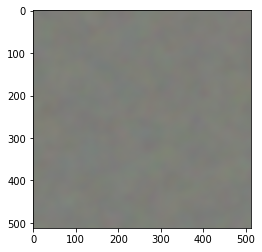

psnr =  10.916771177724755
ssim =  0.66754836
3.6892752647399902


<ipython-input-7-dcb2fb390a4b>:27: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  SSIM = ssim(gt,outputimg,multichannel=True )


Step 500, Total loss 0.036266


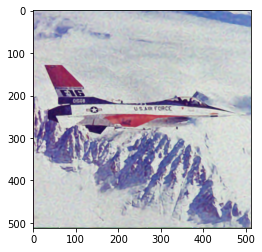

psnr =  30.30204195490522
ssim =  0.9183107
32.178932666778564


In [ ]:
total_steps = 501
steps_til_summary = 500
optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())
model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
start_time=time.time()
for step in range(total_steps+1):
    model_output, coords = img_siren(model_input)    
    loss = ((model_output - ground_truth)**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        
        outputimg=model_output.cpu().view(sidelength1,sidelength2,3).detach().numpy()
        gt = (np.array(Image.open(fname).resize([sidelength2,sidelength1])).astype(np.float32)/255)        
        outputimg=(outputimg+1)/2     
        
       
       
        plt.imshow((model_output.cpu().view(sidelength1,sidelength2,3).detach().numpy()+1)/2)
        plt.pause(0.1)
        
        PSNR = psnr(gt,outputimg)
        print("psnr = ", PSNR)
                
        
        SSIM = ssim(gt,outputimg,multichannel=True )
        print("ssim = ", SSIM)
        end_time=time.time()
        print(end_time-start_time)
        
        
    
    optim.zero_grad()
    loss.backward()
    optim.step()
# save
# b=np_to_pil(outputimg.transpose(2,0,1))
# b.save('inrk12.png')
